# T09 Resampling

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import pandas as pd
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from ISLP import load_data
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import LeaveOneOut, cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

## 1

Deriva $Var(\alpha X + (1-\alpha)Y)$ para demostrar que $\alpha$ sí es óptimo.Partimos de la definición de la varianza para un portafolio de dos activos:$$Var[\alpha X + (1-\alpha)Y] = \alpha^2 Var[X] + (1-\alpha)^2 Var[Y] + 2\alpha(1-\alpha)Cov[X,Y]$$

Sustituyendo por la notación de sigma ($\sigma$):$$= \alpha^2 \sigma_X^2 + (1-\alpha)^2 \sigma_Y^2 + 2\alpha(1-\alpha)\sigma_{XY}$$

Ahora derivamos respecto a $\alpha$ para encontrar la varianza mínima:$$\frac{dVar}{d\alpha} = \frac{d}{d\alpha}[\alpha^2 \sigma_X^2] + \frac{d}{d\alpha}[(1-\alpha)^2 \sigma_Y^2] + \frac{d}{d\alpha}[2\alpha(1-\alpha)\sigma_{XY}]$$
$$= 2\alpha \sigma_X^2 - 2(1-\alpha)\sigma_Y^2 + 2(1-2\alpha)\sigma_{XY}$$

Igualamos a 0 y despejamos $\alpha$:$$\alpha \sigma_X^2 - (1-\alpha)\sigma_Y^2 + (1-2\alpha)\sigma_{XY} = 0$$

(Agrupando términos semejantes para despejar $\alpha$):

$$\alpha \sigma_X^2 + \alpha \sigma_Y^2 - 2\alpha \sigma_{XY} = \sigma_Y^2 - \sigma_{XY}$$

$$\alpha (\sigma_X^2 + \sigma_Y^2 - 2\sigma_{XY}) = \sigma_Y^2 - \sigma_{XY}$$

$$\alpha = \frac{\sigma_Y^2 - \sigma_{XY}}{\sigma_X^2 + \sigma_Y^2 - 2\sigma_{XY}}$$

En efecto, esa fórmula para $\alpha$ minimiza la varianza del portafolio.

## 2.

### (a)

Si la probabilidad de elegir un elemento es $p(j) = \frac{1}{n}$, entonces:$$p(\text{no } j) = 1 - \frac{1}{n}$$

### (b)
Bootstrap es con reemplazo, entonces es lo mismo para cada intento:$$1 - \frac{1}{n}$$

### (c)
Como lo vimos en los 2 problemas anteriores, $1 - \frac{1}{n}$ es la probabilidad de que NO sea $j$. Si volvemos a intentar, sería:

Para 2 observaciones consecutivas:
$\left(1 - \frac{1}{n}\right)^2$

Para 3 observaciones:
$\left(1 - \frac{1}{n}\right)^3$

Síguele $n$ veces y será:$$\left(1 - \frac{1}{n}\right)^n$$

Entonces la probabilidad de que SÍ esté (al menos una vez) es el complemento:$$P(\text{SÍ está}) = 1 - \left(1 - \frac{1}{n}\right)^n$$

### (d)
Para $n=5$:$$1 - \left(1 - \frac{1}{5}\right)^5 = 0.672$$

### (e)
Para $n=100$:$$1 - \left(1 - \frac{1}{100}\right)^{100} = 0.634$$

### (f)
Para $n=10,000$:$$1 - \left(1 - \frac{1}{10000}\right)^{10000} = 0.632$$

Se puede notar que se está llegando a cierto límite

Enorme disclaimer para toda la parte de aquí arriba: todo lo hice en mi cuaderno. Luego le tomé foto y le pedí a Gemini que me lo pasara a Latex. Sí lo hice yo.

### (g)

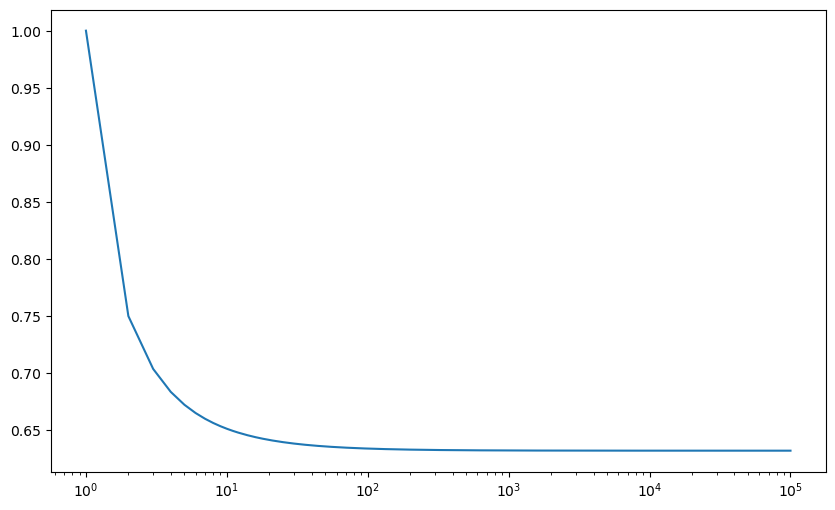

In [2]:
n_values = np.arange(1, 100001)

probabilities = 1 - (1 - 1.0/n_values)**n_values

plt.figure(figsize=(10, 6))
plt.plot(n_values, probabilities)
plt.xscale('log')
plt.show()

Se nota que hay un límite en cuanto a la probabilidad de que j observación Sí esté en el sampling

### (h)

In [3]:
rng = np.random.default_rng(10)
store = np.empty(10000)
for i in range(10000):
    store[i] = np.sum(rng.choice(100, size=100, replace=True) == 4) > 0
np.mean(store)

0.6362

Nota: Este código viene del libro, pero noté que la probabilidad era súper baja, por lo que le pregunte a Gemini porqué estaba pasando eso.

Gemini me dijo que el agregara size=100 porque eso saca 100 valores de una sola y ahora sí calcula la probabilidad de que j=4 estuviera en el sample.

Antes el código lo que hacía era sacar una sola muestra y calcular la probabilidad de que en esa única muestra estuviera j=4

Ahora con esta corrección podemos ver que, incluso en la práctica, la probabilidad es igual que en la teórica

## 3

### (a)

k-folds lo hemos visto varias veces en clase.

Es un método de validación del modelo tipo "train y test" donde se entrena el modelo con una parte de los datos y se prueba su desempeño con la parte restande de los datos. La cosa con k-folds es que hace lo mismo pero hace iteraciones, dándole la vuelta entera a todos los datos para poder usar todos los datos pero no al mismo tiempo. Al final tendrás varios r^2, por lo que les sacas un promedio para generalizar. Es importante sacar la desviación estándar también para saber si es estable y sí puede generalizar.

### (b)

#### i
Ventajas respecto al train test: usas todos los datos sin el mierdo de caer en overfitting

Desventajas respecto al train test: Es más pesado computacionalmente

#### ii
Ventajas respecto a LOOCV: Es más ligero computacionalmente

Desventajas frente a LOOCV: no usas tantos datos como podrías usar, aún sin caer en overfitting

## 4

El cálculo de la desviación estándar de nuestra predicción: 

Muy fácil y sencillamente, tomas el dato Y para cierta X y le restas lo que predijiste para esa misma X.

Elevas al cuadrado la diferencia.

Sumas todas las diferencias cuadradas

Sacas la raíz cuadrada de toda la suma.

Esa es la desviación estándar de nuestra predicción

## 5

### (a)

In [4]:
# Primero hacemos una regresión logistica para predecir default usando balance e income
default =pd.read_csv(r"C:\Users\pablo\OneDrive - ITESO\Semestre 5\Laboratorio de aprendizaje estadístico\Default.csv")
X_2 = default[['balance', 'income']]
y = default['default'].map({'Yes': 1, 'No': 0})
modelo_normal = LogisticRegression()
modelo_normal.fit(X_2, y)

LogisticRegression()

#### i

In [5]:
# Primero validamos usando train-test split
X_train, X_test, y_train, y_test = train_test_split(X_2, y, test_size=0.2, random_state=42)

#### ii

In [6]:
modelo_train = LogisticRegression()
modelo_train.fit(X_train, y_train)

LogisticRegression()

#### iii

In [7]:
# Ahora validamos con la parte de test, clasificándolo a default si su probabilidad es mayor a 0.5
y_pred = modelo_train.predict(X_test)

#### iv

In [8]:
# Ahora sacamos el porcentaje de fracasos
fail_1 = np.mean(y_pred != y_test)
print(f'Failure rate: {fail_1:.4f}')

Failure rate: 0.0305


### (c)

In [9]:
# Repetimos todo otras 2 veces
failures = [fail_1]
for i in range(2):
    X_train, X_test, y_train, y_test = train_test_split(X_2, y, test_size=0.2, random_state=i)
    modelo_train = LogisticRegression()
    modelo_train.fit(X_train, y_train)
    y_pred = modelo_train.predict(X_test)
    fail = np.mean(y_pred != y_test)
    failures.append(fail)

print(f'Los 3 porcentajes de fracaso son: {failures}')

Los 3 porcentajes de fracaso son: [0.0305, 0.028, 0.027]


Todos los porcentajes de error dan casi iguales entre los 3. En ese caso, este modelo es súper bueno para generalizar. Esto pareció como un k folds combinado con resampling porque fue un kfolds de 3 (pero chueco porque agarré 80% de datos) pero con posibilidad de re-escoger.

### (d)

In [10]:
# Hacemos lo mismo pero ahora sí usaremos la variable "student" como dummy
default['student'] = default['student'].map({'Yes': 1, 'No': 0})
X_3 = default[['balance', 'income', 'student']]
y = default['default'].map({'Yes': 1, 'No': 0})
modelo_normal = LogisticRegression()
modelo_normal.fit(X_3, y)

LogisticRegression()

In [11]:
# Primero validamos usando train-test split
X_train, X_test, y_train, y_test = train_test_split(X_3, y, test_size=0.2, random_state=42)

modelo_train = LogisticRegression()
modelo_train.fit(X_train, y_train)

# Ahora validamos con la parte de test, clasificándolo a default si su probabilidad es mayor a 0.5
y_pred = modelo_train.predict(X_test)

# Ahora sacamos el porcentaje de fracasos
fail_1 = np.mean(y_pred != y_test)
print(f'Failure rate: {fail_1:.4f}')

# Repetimos todo otras 2 veces
failures = [fail_1]
for i in range(2):
    X_train, X_test, y_train, y_test = train_test_split(X_3, y, test_size=0.2, random_state=i)
    modelo_train = LogisticRegression()
    modelo_train.fit(X_train, y_train)
    y_pred = modelo_train.predict(X_test)
    fail = np.mean(y_pred != y_test)
    failures.append(fail)

print(f'Los 3 porcentajes de fracaso son: {failures}')

Failure rate: 0.0305
Los 3 porcentajes de fracaso son: [0.0305, 0.0285, 0.026]


El porcentaje de error es casi casi el mismo, significa que 'student' aporta super poquito o literalmente nada a la predicción

## 6

### (a)

In [12]:
# Usando summarize() y sm.GLM() para encontrar los coeficientes y su error estándar
X_df = default[['balance', 'income']]
X_df = sm.add_constant(X_df)
y = default['default'].map({'Yes': 1, 'No': 0})
modelo_sm = sm.GLM(y, X_df)
resultado = modelo_sm.fit()
print(resultado.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                default   No. Observations:                10000
Model:                            GLM   Df Residuals:                     9997
Model Family:                Gaussian   Df Model:                            2
Link Function:               Identity   Scale:                        0.028217
Method:                          IRLS   Log-Likelihood:                 3651.3
Date:                Tue, 25 Nov 2025   Deviance:                       282.08
Time:                        10:34:58   Pearson chi2:                     282.
No. Iterations:                     3   Pseudo R-squ. (CS):             0.1316
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0922      0.006    -15.936      0.0

### (b) y (c)

In [13]:
def boot_fn(data, indices):
    sample = data.iloc[indices]
    X_sample = sample[['balance', 'income']]
    y_sample = sample['default'].map({'Yes': 1, 'No': 0})
    model = sm.GLM(y_sample, sm.add_constant(X_sample))
    result = model.fit()
    #Ahora queremos que nos dé los coeficientes y sus errores estándar
    return result.params[0], result.params[1], result.params[2], result.bse[0], result.bse[1], result.bse[2]

# Y probamos la función
boot_fn(default, np.arange(len(default)))
print(f"intercept coef: {boot_fn(default, np.arange(len(default)))[0]:.4f}")
print(f"balance coef: {boot_fn(default, np.arange(len(default)))[1]:.4f}")
print(f"income coef: {boot_fn(default, np.arange(len(default)))[2]:.4f}")
print(f"intercept std err: {boot_fn(default, np.arange(len(default)))[3]:.4f}")
print(f"balance std err: {boot_fn(default, np.arange(len(default)))[4]:.4f}")
print(f"income std err: {boot_fn(default, np.arange(len(default)))[5]:.4f}")

intercept coef: -0.0922
balance coef: 0.0001
income coef: 0.0000
intercept std err: 0.0058
balance std err: 0.0000
income std err: 0.0000


### (d)

Los coeficientes y sus errores estándar son igualitos a los que salen en el summary()

## 7

In [14]:
Weekly = load_data('Weekly')

print(Weekly.head())

   Year   Lag1   Lag2   Lag3   Lag4   Lag5    Volume  Today Direction
0  1990  0.816  1.572 -3.936 -0.229 -3.484  0.154976 -0.270      Down
1  1990 -0.270  0.816  1.572 -3.936 -0.229  0.148574 -2.576      Down
2  1990 -2.576 -0.270  0.816  1.572 -3.936  0.159837  3.514        Up
3  1990  3.514 -2.576 -0.270  0.816  1.572  0.161630  0.712        Up
4  1990  0.712  3.514 -2.576 -0.270  0.816  0.153728  1.178        Up


### (a)

In [15]:
# Regresión logística para predecir Direction usando Lag1 y Lag2
X_weekly = Weekly[['Lag1', 'Lag2']]
y_weekly = Weekly['Direction'].map({'Up': 1, 'Down': 0}).astype(int)

# Ajuste con scikit-learn
modelo_weekly = LogisticRegression()
modelo_weekly.fit(X_weekly, y_weekly)

# Mostrar coeficientes de scikit-learn
print("Sklearn LogisticRegression")
print("Intercept:", modelo_weekly.intercept_)
print("Coefficients (Lag1, Lag2):", modelo_weekly.coef_.ravel())

# Obtener un resumen estadístico usando statsmodels (sm ya está importado en otra celda)
X_sm = sm.add_constant(X_weekly)
modelo_sm_weekly = sm.Logit(y_weekly, X_sm)
resultado_weekly = modelo_sm_weekly.fit(disp=False)
print("\nStatsmodels Logit summary:")
print(resultado_weekly.summary())

Sklearn LogisticRegression
Intercept: [0.22122423]
Coefficients (Lag1, Lag2): [-0.03869725  0.06020635]

Statsmodels Logit summary:
                           Logit Regression Results                           
Dep. Variable:              Direction   No. Observations:                 1089
Model:                          Logit   Df Residuals:                     1086
Method:                           MLE   Df Model:                            2
Date:                Tue, 25 Nov 2025   Pseudo R-squ.:                0.005335
Time:                        10:34:59   Log-Likelihood:                -744.11
converged:                       True   LL-Null:                       -748.10
Covariance Type:            nonrobust   LLR p-value:                   0.01848
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2212      0.061      3.599      0.000       0.101       0.342

### (b)

In [16]:
# Lo mismo pero tiramos el primer dato
X_weekly_dropped = X_weekly.iloc[1:]
y_weekly_dropped = y_weekly.iloc[1:]

# Ajuste con scikit-learn
modelo_weekly_dropped = LogisticRegression()
modelo_weekly_dropped.fit(X_weekly_dropped, y_weekly_dropped)

# Mostrar coeficientes de scikit-learn
print("Sklearn LogisticRegression")
print("Intercept:", modelo_weekly_dropped.intercept_)
print("Coefficients (Lag1, Lag2):", modelo_weekly_dropped.coef_.ravel())

# Obtener un resumen estadístico usando statsmodels (sm ya está importado en otra celda)
X_sm_dropped = sm.add_constant(X_weekly_dropped)
modelo_sm_weekly_dropped = sm.Logit(y_weekly_dropped, X_sm_dropped)
resultado_weekly_dropped = modelo_sm_weekly_dropped.fit(disp=False)
print("\nStatsmodels Logit summary:")
print(resultado_weekly_dropped.summary())

Sklearn LogisticRegression
Intercept: [0.22324303]
Coefficients (Lag1, Lag2): [-0.03840843  0.06080518]

Statsmodels Logit summary:
                           Logit Regression Results                           
Dep. Variable:              Direction   No. Observations:                 1088
Model:                          Logit   Df Residuals:                     1085
Method:                           MLE   Df Model:                            2
Date:                Tue, 25 Nov 2025   Pseudo R-squ.:                0.005387
Time:                        10:34:59   Log-Likelihood:                -743.26
converged:                       True   LL-Null:                       -747.29
Covariance Type:            nonrobust   LLR p-value:                   0.01785
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2232      0.061      3.630      0.000       0.103       0.344

### (c)

In [17]:
# Usamos el modelo sin un dato para predecir el dato que tiramos
modelo_weekly_dropped.predict(X_weekly.iloc[0:1])

array([1])

Bruhhh está mal

### (d)

In [18]:
# Hacemos un loop manual para hacer LOOCV
n = len(Weekly)
errors = []
for i in range(n):
    #### (i)
    X_train = X_weekly.drop(index=i)
    y_train = y_weekly.drop(index=i)
    X_test = X_weekly.iloc[i:i+1]
    y_test = y_weekly.iloc[i:i+1]
    
    modelo_loocv = LogisticRegression()
    modelo_loocv.fit(X_train, y_train)
    
    #### (ii)
    y_pred = modelo_loocv.predict(X_test)

    #### (iii)
    error = int(y_pred != y_test)

    ##### (iv)
    errors.append(error)

### (e)

In [19]:
loocv_error_rate = np.mean(errors)
print(f'LOOCV Error Rate: {loocv_error_rate:.4f}')

LOOCV Error Rate: 0.4500


Vaya que se equivoca bastante este modelo; no es nada bueno para generalizar.

## 8

### (a)

In [20]:
rng = np.random.default_rng(1)
x = rng.normal(size=100)
y = x - 2 * x**2 + rng.normal(size=100)

En este caso n = 100 y p = 1

### (b)

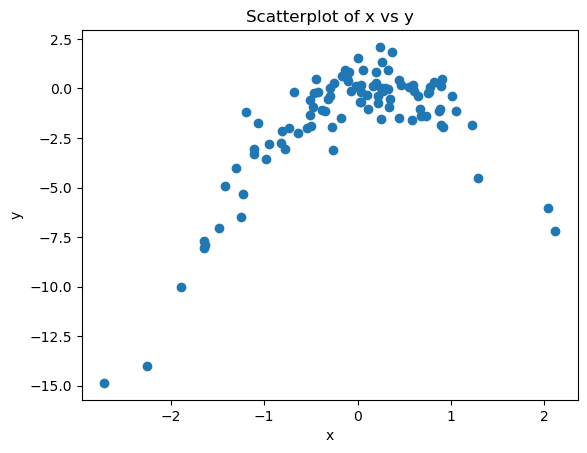

In [21]:
# Creamos un scatterplot de x y y
plt.scatter(x, y)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Scatterplot of x vs y')
plt.show()

### (c)

#### (i)

In [22]:
df = pd.DataFrame({'x': x, 'y': y})

# 2. Preparamos el objeto LOOCV
loo = LeaveOneOut()

for degree in [1, 2, 3, 4]:
    # Creamos un 'Pipeline':
    # Paso A: Generar las potencias (x, x^2, etc.)
    # Paso B: Ajustar regresión lineal a esas potencias
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())

    # cross_val_score hace todo el trabajo sucio del LOOCV
    # 'neg_mean_squared_error' se usa porque sklearn maximiza scores (por eso devuelve negativo)
    scores = cross_val_score(model, df[['x']], df['y'], cv=loo, scoring='neg_mean_squared_error')
    
    # Convertimos a positivo y sacamos el promedio
    mse = np.mean(np.abs(scores))
    
    print(f"Modelo {degree} (Polinomio grado {degree}): MSE = {mse:.5f}")

Modelo 1 (Polinomio grado 1): MSE = 6.63303
Modelo 2 (Polinomio grado 2): MSE = 1.12294
Modelo 3 (Polinomio grado 3): MSE = 1.30180
Modelo 4 (Polinomio grado 4): MSE = 1.33239


### (d)

La verdad no veía dónde poner el random seed. Le pregunté a Gemini y me dijo que justo eso era lo que el libro quería que vieramos: que no afectaría el resultado cambiar la random seed.

La razón por la que no cambia el resultado es porque no hay maneras aleatorias DIFERENTES de mezclar un LOOCV. Eso sí aplicaría para un k-folds pero aquí no porque solo hay una manera de hacerlo.

### (e)

El modelo de grado 2 fue el de menor error y claro que es el que era de esperarse.

Obvio es el modelo 2 porque nosotros mismos generamos los datos con x - 2x^2

### (f)

In [23]:
for degree in [1, 2, 3, 4]:
    #Usando np.vander se crea la matriz de polinomios
    model = sm.OLS(y, sm.add_constant(np.vander(x, N=degree+1, increasing=True)))
    results = model.fit()
    print(f"Modelo {degree} (Polinomio grado {degree}):")
    print(results.summary())

Modelo 1 (Polinomio grado 1):
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.318
Model:                            OLS   Adj. R-squared:                  0.311
Method:                 Least Squares   F-statistic:                     45.60
Date:                Tue, 25 Nov 2025   Prob (F-statistic):           1.04e-09
Time:                        10:35:05   Log-Likelihood:                -230.83
No. Observations:                 100   AIC:                             465.7
Df Residuals:                      98   BIC:                             470.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.4650 

Todos los resultados tienen sentido. 

Modelo 1: Muy significante x1 pero el r2 del modelo es bajo.

Modelo 2: Muy significantes ambos x1 y x2 y el r2 es alto.

Modelo 3: Primeros 2 x son significantes pero x3 ya casi no. El r2 casi no cambia.

Modelo 4: Primeros 2 x son significantes pero los últimos 2 ya no. El r2 casi no cambia.

## 9

In [24]:
boston = load_data('Boston')
boston.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2


### (a)

In [25]:
mu_gorro = np.mean(boston['medv'])
mu_gorro

22.532806324110677

### (b)

In [26]:
SE_mu = np.std(boston['medv']) / np.sqrt(len(boston))
SE_mu

0.4084569346972867

### (c)

In [27]:
# Hacemos lo mismo pero con bootstrap
B = 1000
mu_bootstrap = np.array([])
for i in range(B):
    sample_indices = np.random.choice(len(boston), size=len(boston), replace=True)
    sample = boston.iloc[sample_indices]
    mu_b = np.mean(sample['medv'])
    mu_bootstrap = np.append(mu_bootstrap, mu_b)
mu_bootstrap_std = np.std(mu_bootstrap)
mu_bootstrap_std

0.4094099717328148

Una media bastante parecida

### (d)

In [28]:
print(f"Intervalo de confianza medv original: [{mu_gorro - 1.96*SE_mu:.2f}, {mu_gorro + 1.96*SE_mu:.2f}]")
print(f"Intervalo de confianza medv bootstrap: [{mu_gorro - 1.96*mu_bootstrap_std:.2f}, {mu_gorro + 1.96*mu_bootstrap_std:.2f}]")

Intervalo de confianza medv original: [21.73, 23.33]
Intervalo de confianza medv bootstrap: [21.73, 23.34]


Suuuuper pero súper parecidísimos.

Me encanta la estadística. Algo tan ilógico como "inventarse datos" puede llegar a ser confiable si se sabe de estadística. 

### (e)

In [29]:
mediana_original = np.median(boston['medv'])
mediana_original

21.2

### (f)

In [30]:
# Ahora encontraremos el error estándar de la mediana usando bootstrap
B = 1000
mediana_bootstrap = np.array([])
for i in range(B):
    sample_indices = np.random.choice(len(boston), size=len(boston), replace=True)
    sample = boston.iloc[sample_indices]
    mediana_b = np.median(sample['medv'])
    mediana_bootstrap = np.append(mediana_bootstrap, mediana_b)
mediana_bootstrap_std = np.std(mediana_bootstrap)
mediana_bootstrap_std

0.3789193053936415

Es una media bastante sólida, que se parezca también al promedio lo reafirma.

### (g)

In [31]:
medv_percentil_10 = np.percentile(boston['medv'], 10)
medv_percentil_10

12.75

In [32]:
# Ahora encontraremos el error estándar del percentil 10 usando bootstrap
B = 1000
percentil_10_bootstrap = np.array([])
for i in range(B):
    sample_indices = np.random.choice(len(boston), size=len(boston), replace=True)
    sample = boston.iloc[sample_indices]
    percentil_10_b = np.percentile(sample['medv'], 10)
    percentil_10_bootstrap = np.append(percentil_10_bootstrap, percentil_10_b)
percentil_10_bootstrap_std = np.std(percentil_10_bootstrap)
percentil_10_bootstrap_std

0.4853696632464785

Tantito más variable pero igual sólido.